In [2]:
from neo.io import AxonIO
from scipy.interpolate import UnivariateSpline

from utils import get_filenames, despine_ax
from loaders import LFPRecording

plt.style.use('jns')

In [3]:
LW_BAR = 1.5

In [4]:
files = sorted(get_filenames('data/base recordings/TTX/', contains='abf'))
files_controls = sorted(get_filenames('data/base recordings/TTX/controls', contains='abf'))

In [27]:
len(files), len(files_controls)

(19, 12)

In [5]:
# filename = files[6]
# sig = 0
# reader = AxonIO(filename=filename)
# seg = reader.read_segment()
# signal = np.array(seg.analogsignals[sig])[:,1]

In [6]:
def round_duration(dur_exact):
    exponent = np.floor(np.log10(dur_exact))
    dec = 10 ** exponent
    return np.round(dur_exact / dec) * dec

def read_file(file):
    rec = LFPRecording.from_abf(file, cutoff=15)
    sig = 0
    reader = AxonIO(filename=file)
    seg = reader.read_segment()
    dt = seg.analogsignals[0].sampling_period.base.item()
    valve = np.array(seg.analogsignals[sig])[:,1]
    tarr = np.arange(len(valve)) * dt
    
    open_ixs = np.argwhere((valve[1:] > 0.15) & (valve[:-1] <= 0.15)).flatten()
    openings = np.array([tarr[:-1][ix] for ix in open_ixs])
    
    close_ixs = np.argwhere((valve[1:] < -0.15) & (valve[:-1] >= -0.15)).flatten()
    closings = np.array([tarr[:-1][ix] for ix in close_ixs])
    
    durations = closings - openings
    
    responses = {}
    
    for i in range(3):
        rd = round_duration(durations[i])
        tarr, varr = rec.segment(openings[i]-1, closings[i]+2).to_arrays()
        
        base_mask = (tarr > openings[i]-1) & (tarr < openings[i]-0.1)
        
        f = UnivariateSpline(tarr-openings[i], varr-varr[base_mask].mean(), s=0, k=1)
        
        xx = np.arange(-1, 4, 0.001)
        responses[rd] = (xx, f(xx))
        
    return responses

In [7]:
# rec = LFPRecording.from_abf(files[0], cutoff=15)

In [8]:
# for file in files:
#     reader = AxonIO(filename=file)

#     seg = reader.read_segment()
#     dt = seg.analogsignals[0].sampling_period.base.item()
#     valve = np.array(seg.analogsignals[sig])[:,1]
#     tarr = np.arange(len(valve)) * dt

#     open_ixs = np.argwhere((valve[1:] > 0.15) & (valve[:-1] <= 0.15)).flatten()
#     openings = np.array([tarr[:-1][ix] for ix in open_ixs])

#     plt.figure()
#     plt.plot(valve[1:])

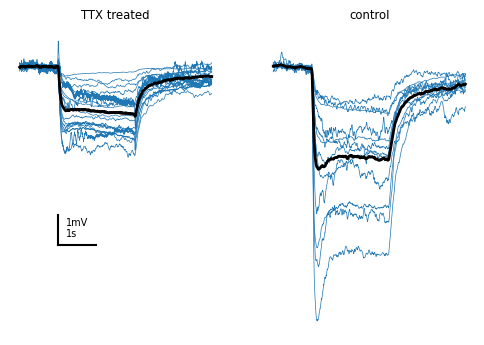

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(6,4), sharey=True)

def plot_ttx(axes):
    # excluded_lists = [
    #     # [0, 1, 3, 4, 5, 10 ,11, 12, 13, 14, 15, 16],
    #     [0], []
    #     # [3, 4, 6, 8, 9, 10, 11]
    # ]
    excluded_lists = [
        [0, 1],
        []
    ]

    for files_list, elist, ax in zip([files, files_controls], excluded_lists, axes):
        pairs = []

        for i, file in enumerate(files_list):#[files[i] for i in [2,6,7,8,9]]:
            if i in elist:
                continue

            recordings = read_file(file)

            pairs.append(recordings[2])

        varrs = np.array([p[1] for p in pairs])
        tarr = pairs[0][0]
        varr_mean = varrs.mean(axis=0)

        for varr in varrs:
            ax.plot(tarr, varr, c='C0', lw=0.5)

        ax.plot(tarr, varr_mean, c='black', lw=2)

    #     ax.set_xlabel('time (s)')
        despine_ax(ax)

    # axes[0].set_ylabel('LFP (mV)')

    axes[0].plot([0,0],[-3-2,-4-2], color='black', lw=LW_BAR)
    axes[0].plot([0,1],[-4-2,-4-2], color='black', lw=LW_BAR)
    axes[0].text(0.2, -3.75-2, '1mV\n1s', ha='left')

    axes[0].set_title('TTX treated', loc='center')
    axes[1].set_title('control', loc='center')


    
plot_ttx(axes)
# plt.savefig('img/ttx_full.png')

# Multicompartmental model

In [10]:
from scipy.integrate import solve_ivp
from lfpmodel import deriv_receptor, get_stim_func
from lfpan import get_means
from multicomp import deriv_known_LFP, deriv_known_Vis
from utils import filter_expon, rescale, filter_from_coefs
from scipy.interpolate import interp1d, UnivariateSpline

In [11]:
params = np.array([ 1., 2.2, 12, 14, 28])
conc, *deriv_params = params

max_step = 1e-3
t_min = -0.1
t_max = 3
tarr = np.linspace(t_min, t_max, 50000)

args = (get_stim_func(2, conc), *deriv_params)
y0 = np.array([1, 0, 0])
res_lfp = solve_ivp(deriv_receptor, t_span=(t_min,t_max), y0=y0, args=args, t_eval=tarr, max_step=max_step)
rescaling = 7.3
LFP = UnivariateSpline(tarr*1000, 35-res_lfp.y[2]*rescaling, k=1, s=0, ext=3)

In [12]:
shapes = [1, 1, 1]
taus = [1e-3, 40e-3, 0.8]

dt = tarr[1] - tarr[0]

tarr_filt, filt = filter_from_coefs([-96, 81, 15.5], taus, shapes, dt)

firing = np.convolve(-res_lfp.y[2]*rescaling, filt[::1], mode='full')[:-len(filt)+1]

In [13]:
%%time

ret_Ir = True

if ret_Ir:
    y0 = (35, -62, 35, -62, 0, 0, 0, 0, 0, 0)
else:
    y0 = (35,-62, 35,-62)


res = solve_ivp(lambda t, y: deriv_known_LFP(t, y, LFP, ret_Ir=ret_Ir),
          t_span=(t_min*1000,t_max*1000), y0=y0, t_eval=tarr*1000,
               max_step=1e-1)

if ret_Ir:
    Vea, Vis, Ved, Vid, Ir, Ie, Ild, Ia, Ii, Ils = res.y
else:
    Vea, Vis, Ved, Vid = res.y
    
Ir, Ie, Ild, Ia, Ii, Ils = np.array([deriv_known_LFP(t, x, LFP, ret_Ir=True)[4:] for x, t in zip(res.y.T, tarr*1000)]).T

CPU times: user 20.3 s, sys: 46.5 ms, total: 20.4 s
Wall time: 18 s


In [14]:
q = 30

soma_adapt = UnivariateSpline(tarr*1000, firing/q-62, k=1, s=0, ext=3)
soma_intact = UnivariateSpline(tarr*1000, Vis, k=1, s=0, ext=3)
input_current = UnivariateSpline(tarr*1000, Ir, k=1, s=0, ext=3)

In [15]:
def potentials_adapting(adapt_type):
    ret_Ir = False

    if ret_Ir:
        y0 = (35, -62, 35, -62, 0, 0, 0, 0, 0, 0)
    else:
        y0 = (35,-62, 35,-62)

        
    if adapt_type == 'thr':
        soma = soma_intact
    elif adapt_type == 'ahp':
        soma = soma_adapt

    res = solve_ivp(lambda t, y: deriv_known_Vis(t, y, input_current, soma, ret_Ir=ret_Ir),
              t_span=(t_min*1000,t_max*1000), y0=y0, t_eval=tarr*1000,
                   max_step=1e-1)

    if ret_Ir:
        Vea, Vis, Ved, Vid, Iad, Ie, Ild, Ia, Ii, Ils = res.y
    else:
        Vea, Vis, Ved, Vid = res.y
    
    Iad, Ie, Ild, Ia, Ii, Ils = np.array([deriv_known_Vis(t, x, input_current, soma, ret_Ir=True)[4:] for x, t in zip(res.y.T, tarr*1000)]).T
    
    return Vea, Vis, Ved, Vid

In [16]:
%%time

Vea_thr, Vis_thr, Ved_thr, Vid_thr = potentials_adapting('thr')
Vea_ahp, Vis_ahp, Ved_ahp, Vid_ahp = potentials_adapting('ahp')

CPU times: user 44.1 s, sys: 11.7 ms, total: 44.1 s
Wall time: 44.1 s


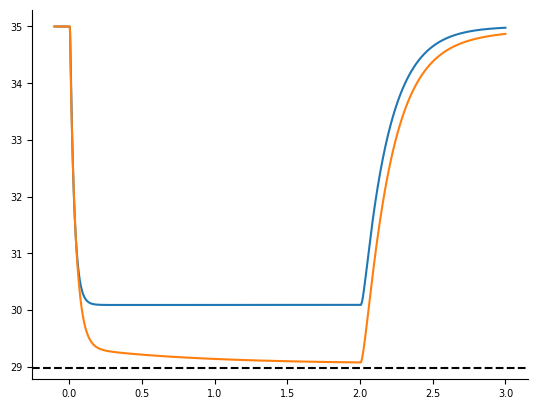

In [17]:
plt.plot(tarr, Ved_thr)
plt.plot(tarr, Ved_ahp)
plt.axhline(Ved_ahp.min()-0.1, linestyle='dashed', color='black')

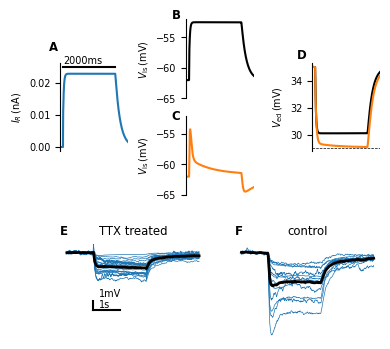

In [26]:
fig = plt.figure(figsize=(3.2, 3.2))

gs_soma = fig.add_gridspec(5, 5, top=1, bottom=0.45, left=0, right=1,
                          width_ratios=[1., 0.4, 1, 0.4, 1], height_ratios=[1,1,0.001,1,1],
                           hspace=0.3, wspace=0.3)

mask = (tarr > -0.05) & (tarr < 2.5)

ax1 = fig.add_subplot(gs_soma[1:4,0])
ax1.plot(tarr[mask], Ir[mask], color='C0')

ax2 = fig.add_subplot(gs_soma[0:2,2])
ax3 = fig.add_subplot(gs_soma[3:5,2])

ax2.plot(tarr[mask], Vis_thr[mask], color='black')
ax3.plot(tarr[mask], Vis_ahp[mask], color='C1')

ax4 = fig.add_subplot(gs_soma[1:4,4])
ax4.plot(tarr[mask], Ved_thr[mask], color='black')
ax4.plot(tarr[mask], Ved_ahp[mask], color='C1')
ax4.axhline(Ved_ahp.min()-0.05, linestyle='dashed', color='black', lw=0.5)

axes = [ax1, ax2, ax3, ax4]

letters = ['A','B','C','D']

titles = [
    {'label': 'A', 'x': -0.1, 'y': 1.05},
    {'label': 'B', 'x': -0.15, 'y': .9},
    {'label': 'C', 'x': -0.15, 'y': .85},
    {'label': 'D', 'x': -0.15, 'y': .95},
]
for ax, kwargs in zip(axes, titles):
    ax.set_xlim(-0.1, 2.5)
    despine_ax(ax, where='b')
    ax.set_title(**kwargs, fontweight='bold')
    
axes[0].plot([0,2], [0.025, 0.025], color='black', lw=LW_BAR)
axes[0].text(x=0, y=0.026, s='2000ms')


for ax in axes[1:3]:
    ax.set_ylim(-65, -52)
    ax.set_ylabel(r'$V_\mathrm{is}\,\mathrm{(mV)}$')

axes[0].set_ylabel(r'$I_R\,\mathrm{(nA)}$')
axes[3].set_ylabel(r'$V_\mathrm{ed}\,\mathrm{(mV)}$')

gs_ttx = fig.add_gridspec(1, 2, top=0.3, bottom=0.0, left=0, right=1,
                          hspace=0.)

axes = np.array([fig.add_subplot(gs_ttx[i]) for i in range(2)])
plot_ttx(axes)
axes[0].set_title('E', loc='left', weight='bold')
axes[1].set_title('F', loc='left', weight='bold')

axes[0].set_ylim(-9, 1)
axes[1].set_ylim(-9, 1)

plt.savefig('img/ttx.png')

In [30]:
len(axes)

2